## Drifters and Cmems data Notebook

### Introduction
This notebook aims to add the Ekman current components to the geostrophic components. Then, it extracts the inertial current components from drifter data using the spline smoothing filter with the functional approach of Ramsay and Silverman at a 24-hour resolution.


### Data Sources
- Drifter Data:
  - Source: NOAA
  - Collection Frequency: Every 6 hours
  - Total Number of Drifters: 230
  - link : https://erddap.aoml.noaa.gov/gdp/erddap/tabledap/drifter_6hour_qc.html
  - period : 01-01-2022 to 01-01-2023

- CMEMS Data:
  - Source: Copernicus Marine
  - Collection Frequency: Every 24 hours
  - Data Product:  SEALEVEL_GLO_PHY_L4_MY_008_047 and MULTIOBS_GLO_PHY_MYNRT_015_003
  - link : https://doi.org/10.48670/moi-00148 and https://doi.org/10.48670/mds-00327
  - download data : ahttps://data.marine.copernicus.eu/product/SEALEVEL_GLO_PHY_L4_MY_008_047/download and https://data.marine.copernicus.eu/product/MULTIOBS_GLO_PHY_MYNRT_015_003/download
  - period : 01-01-2022 to 01-01-2023

### Tasks

#### 1. Interpolation CMEMS data

 - Interpolation of geostrophic and Ekman components (DUACS current) over the spatial and temporal grid of the drifter.

#### 2. Total CMEMS currents
 - Adding the surface Ekman current to the geostrophic current.
 -  Using the spline smoothing filter with the functional approach of Ramsay and Silverman at a 24-hour resolution to extract the inertial current components.
 -  conclusion

#### 1. Interpolation CMEMS data

## Import Library

In [16]:
import pandas as pd
import numpy as np
import xarray as xr
import utils as ut
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.interpolate import interp2d

from scipy.signal import hann, convolve

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
from cartopy import config
import matplotlib.animation
from scipy.stats import linregress
from scipy.stats import pearsonr

## Read Drifter Data

In [17]:
fn='./drifter_6hour_qc_a65f_894f_fcdf_U1719475759871.nc';
ds=xr.open_dataset(fn);

C:\ProgramData\anaconda3\Lib\site-packages\xarray\coding\times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
C:\ProgramData\anaconda3\Lib\site-packages\xarray\coding\times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


## Extract Coordinates and Variables

In [18]:
ve_curr = ds.ve.values
vn_curr = ds.vn.values
sst = ds.sst.values
lon = ds.longitude.values
lat = ds.latitude.values
time = ds.time.values

## Creation of Pandas Array for Drifter Data

In [19]:
data = {
    'longitude': lon,
    'latitude' : lat,
    'time'     : time,
    've'       : ve_curr,
    'vn'       : vn_curr,
    'sst'      : sst
}

df = pd.DataFrame(data)
df

,longitude,latitude,time,ve,vn,sst
0,-7.635,-15.792,2022-10-21 00:00:00,-999999.00000,-999999.00000,20.451
1,-7.653,-15.807,2022-10-21 06:00:00,-0.08591,-0.03578,20.405
2,-7.670,-15.806,2022-10-21 12:00:00,-0.12948,-0.02212,20.487
3,-7.705,-15.816,2022-10-21 18:00:00,-0.17363,-0.08763,20.549
4,-7.740,-15.840,2022-10-22 00:00:00,-0.15634,-0.12047,20.453
...,...,...,...,...,...,...
107567,-32.437,-8.640,2022-12-31 00:00:00,-0.18780,-0.12320,27.967
107568,-32.466,-8.648,2022-12-31 06:00:00,-0.14889,-0.02632,27.904
107569,-32.496,-8.650,2022-12-31 12:00:00,-0.09390,-0.01295,27.928
107570,-32.503,-8.653,2022-12-31 18:00:00,-0.02304,-0.04897,27.977


## Selecting Drifter Data

In [20]:
# Test: Our selected drifter has 813 observations. 
 
df_1 = df[53965:54778]
df_1

,longitude,latitude,time,ve,vn,sst
53965,-55.837,18.012,2022-01-01 00:00:00,-0.18000,0.17501,26.919
53966,-55.870,18.034,2022-01-01 06:00:00,-0.16960,0.11943,26.932
53967,-55.907,18.058,2022-01-01 12:00:00,-0.15112,0.04225,26.936
53968,-55.932,18.051,2022-01-01 18:00:00,-0.13265,-0.05243,26.936
53969,-55.961,18.038,2022-01-02 00:00:00,-0.09443,-0.08665,26.958
...,...,...,...,...,...,...
54773,-62.615,18.135,2022-07-22 00:00:00,-0.14837,0.10376,28.743
54774,-62.643,18.137,2022-07-22 06:00:00,-0.20508,-0.03377,28.492
54775,-62.698,18.121,2022-07-22 12:00:00,-0.34088,-0.04629,28.384
54776,-62.782,18.119,2022-07-22 18:00:00,-0.38639,0.00328,28.401


# Arrange to begin with index 0

In [21]:
ve_curr_2 = df_1.ve.values
vn_curr_2 = df_1.vn.values
sst_2 = df_1.sst.values
lon_2 = df_1.longitude.values
lat_2 = df_1.latitude.values
time_2 = df_1.time.values

In [22]:
data = {
    'longitude': lon_2,
    'latitude' : lat_2,
    'time'     : time_2,
    've'       : ve_curr_2,
    'vn'       : vn_curr_2,
    'sst'      : sst_2
}

df_2 = pd.DataFrame(data)
df_2

,longitude,latitude,time,ve,vn,sst
0,-55.837,18.012,2022-01-01 00:00:00,-0.18000,0.17501,26.919
1,-55.870,18.034,2022-01-01 06:00:00,-0.16960,0.11943,26.932
2,-55.907,18.058,2022-01-01 12:00:00,-0.15112,0.04225,26.936
3,-55.932,18.051,2022-01-01 18:00:00,-0.13265,-0.05243,26.936
4,-55.961,18.038,2022-01-02 00:00:00,-0.09443,-0.08665,26.958
...,...,...,...,...,...,...
808,-62.615,18.135,2022-07-22 00:00:00,-0.14837,0.10376,28.743
809,-62.643,18.137,2022-07-22 06:00:00,-0.20508,-0.03377,28.492
810,-62.698,18.121,2022-07-22 12:00:00,-0.34088,-0.04629,28.384
811,-62.782,18.119,2022-07-22 18:00:00,-0.38639,0.00328,28.401


## Now let's interpolate the CMEMS data onto the grid of the drifter data.

### Case of Geostrophic Velocity ugosa and  vgosa

In [23]:
# Loading drifting buoy data from the DataFrame
df_bouees = df_2 
# Suppose your DataFrame contains columns 'time', 'latitude', and 'longitude'

# Loading satellite data from the netCDF file
ds_satellitaires = xr.open_dataset('cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_1719675910724.nc') 
# Suppose your satellite data is stored in variables called 'ugosa' and 'vgosa'

# Extracting satellite current data for the same spatial and temporal positions as the buoys
latitudes = df_bouees['latitude']
longitudes = df_bouees['longitude']
temps = df_bouees['time']

satellitaires_courant_u = []
for i in range(len(df_bouees)):
    lat = latitudes[i]
    lon = longitudes[i]
    time = temps[i]
    courant = ds_satellitaires['ugosa'].interp(latitude=lat, longitude=lon, time=time).values
    satellitaires_courant_u.append(courant)

satellitaires_courant_v = []
for i in range(len(df_bouees)):
    lat = latitudes[i]
    lon = longitudes[i]
    time = temps[i]
    courant = ds_satellitaires['vgosa'].interp(latitude=lat, longitude=lon, time=time).values
    satellitaires_courant_v.append(courant)

### Case of zonal and meridional ekman Component of 15m deep  current (ue) and (ve)

In [24]:
# Loading drifting buoy data from the DataFrame
df_bouees = df_2
# Suppose your DataFrame contains columns 'time', 'latitude', and 'longitude' 

# Loading satellite wind data from the netCDF file
ds_ek = xr.open_dataset('cmems_obs_mob_glo_phy-cur_my_0.25deg_P1D-m_1719676287157.nc')   
 
# Suppose your satellite wind data is stored in variables called 'eastward_wind' and 'northward_wind'

# Extracting satellite wind data for the same spatial and temporal positions as the buoys
latitudes = df_bouees['latitude']
longitudes = df_bouees['longitude']
temps = df_bouees['time']

satellite_ue = []
for i in range(len(df_bouees)):
    lat = latitudes[i]
    lon = longitudes[i]
    time = temps[i]
    courant = ds_ek['ue'].interp(latitude=lat, longitude=lon, time=time).values
    satellite_ue.append(courant)

satellite_ve = []
for i in range(len(df_bouees)):
    lat = latitudes[i]
    lon = longitudes[i]
    time = temps[i]
    courant = ds_ek['ve'].interp(latitude=lat, longitude=lon, time=time).values
    satellite_ve.append(courant)

#### 2. Adding the surface Ekman current to the geostrophic current.
-  Adding the surface Ekman current to the geostrophic current (CMEMS current) and conclusion.

## ugeos plus Ekman zonal current

In [25]:
# u_total = u_geostro + u_e_sat
u_total = [a + b for a, b in zip(satellitaires_courant_u, satellite_ue)]

## vgeos plus Ekman meridional current

In [26]:
# u_total = v_geostro + v_e_sat
v_total = [a + b for a, b in zip(satellitaires_courant_v, satellite_ve)]

## Creation of Pandas Array for CMEMS total current Data

In [27]:
data = {
     
    'u_total'       : u_total,
    'v_total'       : v_total
     
}

dF = pd.DataFrame(data)
dF = dF.astype({'u_total': 'float64', 'v_total': 'float64'})
dF

,u_total,v_total
0,-0.008576,0.088888
1,-0.010697,0.089917
2,-0.017104,0.085060
3,-0.010468,0.078064
4,0.000153,0.067501
...,...,...
808,0.022100,0.117150
809,0.014206,0.115558
810,0.001527,0.119835
811,-0.014995,0.124484


## Now Let's Compare Drifter Speeds and  CMEMS Speeds

## Comparison between (ve and u_total) and (vn and v_total)

## Using Regression and Correlation

## case of ve and u_total

Corrélation de Pearson: 0.8050234652046382
Valeur de p (p-value): 4.293743523342581e-186


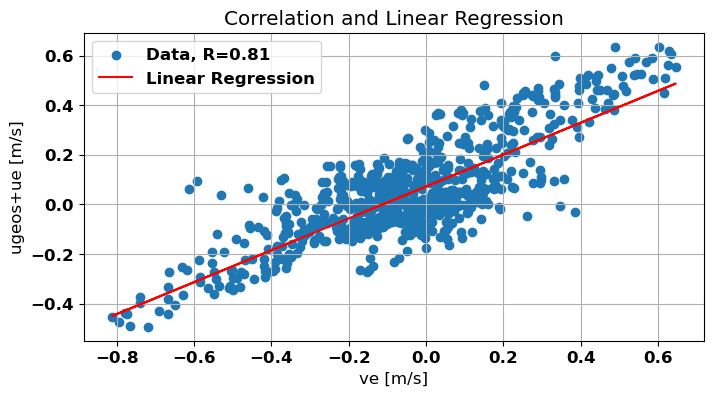

In [28]:
# According to the following, we can simply note that the correlation between "ve" and "ugeos + ue" is 0.81. 
# This means that there is a positive and strong relationship  between this two variables.
# Calcul de la corrélation spatiale et temporelle Pearson
bouees_courant_u = df_2['ve']
correlation, p_value = pearsonr(dF['u_total'],bouees_courant_u)

print("Corrélation de Pearson:", correlation)
print("Valeur de p (p-value):", p_value)

# Fit linear regression model

slope, intercept, _, _, _ = linregress( bouees_courant_u,dF['u_total'])

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(bouees_courant_u,dF['u_total'], label=f'Data, R={correlation:.2f}')
plt.plot(bouees_courant_u, slope*bouees_courant_u + intercept, color='red', label='Linear Regression')
plt.xlabel('ve [m/s]')
plt.ylabel('ugeos+ue [m/s]')
plt.legend()
plt.title('Correlation and Linear Regression')
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'

# save graphe
plt.savefig("fig15 mode.png")
# Show plot
plt.show()

## case of vn and v_total

Corrélation de Pearson: 0.8375427604670649
Valeur de p (p-value): 4.2368397294123825e-215


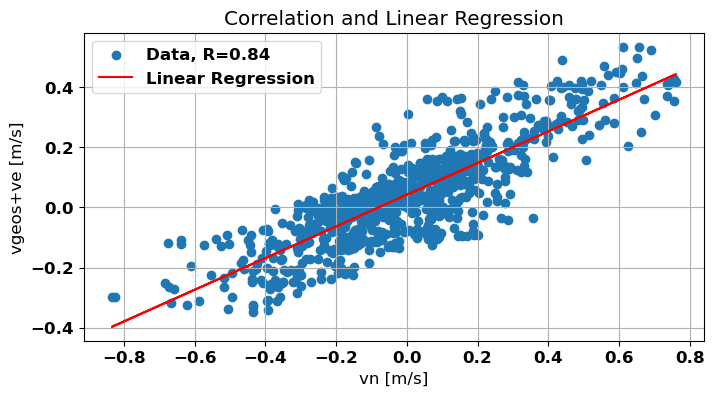

In [29]:
# According to the following, we can simply note that the correlation between "vn" and "vgeos + ve" is 0.84. 
# This means that there is a positive and strong relationship  between this two variables.
# Calcul de la corrélation spatiale et temporelle Pearson
bouees_courant_v = df_2['vn']
correlation, p_value = pearsonr(dF['v_total'],bouees_courant_v)

print("Corrélation de Pearson:", correlation)
print("Valeur de p (p-value):", p_value)

# Fit linear regression model

slope, intercept, _, _, _ = linregress( bouees_courant_v,dF['v_total'])

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(bouees_courant_v,dF['v_total'], label=f'Data, R={correlation:.2f}')
plt.plot(bouees_courant_v, slope*bouees_courant_v + intercept, color='red', label='Linear Regression')
plt.xlabel('vn [m/s]')
plt.ylabel('vgeos+ve [m/s]')
plt.legend()
plt.title('Correlation and Linear Regression')
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'

# save graphe
plt.savefig("fig16 mode.png")
# Show plot
plt.show()

# Application of a linear Hanning filter at a 24-hour resolution.

## Case of ve

In [30]:
 time = np.array(df_2['time'])   
current_data = np.array(df_2['ve'])   

# Parameters of the Hanning filter
window_length = 24  # Length of the Hanning window

# Applying the Hanning filter
window = hann(window_length)  # Create the Hanning window
ve_filter_Han = convolve(current_data, window, mode='same') / sum(window)  # Apply the Hanning filter

C:\Users\PC-M2OA\AppData\Local\Temp\ipykernel_47288\470526075.py:8: DeprecationWarning: Importing hann from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hann' or the convenience function 'scipy.signal.get_window' instead.
  window = hann(window_length)  # Create the Hanning window


## Case of vn

In [31]:
time = np.array(df_2['time'])   
current_data = np.array(df_2['vn'])   

# Parameters of the Hanning filter
window_length = 24  # Length of the Hanning window

# Applying the Hanning filter
window = hann(window_length)  # Create the Hanning window
vn_filter_Han = convolve(current_data, window, mode='same') / sum(window)  # Apply the Hanning filter

C:\Users\PC-M2OA\AppData\Local\Temp\ipykernel_47288\2578851579.py:8: DeprecationWarning: Importing hann from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hann' or the convenience function 'scipy.signal.get_window' instead.
  window = hann(window_length)  # Create the Hanning window


## Comparison between (ve_filter and u_total) and (vn_filter and v_total) 

## Using Regression and Correlation

## Case of ve_filter and u_total

Corrélation de Pearson: 0.806125678910786
Valeur de p (p-value): 5.512949097962881e-187


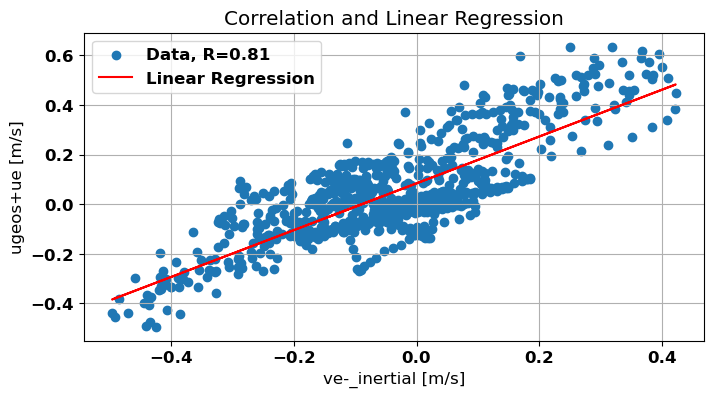

In [32]:
# According to the following, we can simply note that the correlation between "ve_filter" and "ugeos + ue" is 0.81. 
# This means strong relationship between the variables
# Calcul de la corrélation spatiale et temporelle Pearson
bouees_courant_u = ve_filter_Han
correlation, p_value = pearsonr(dF['u_total'],bouees_courant_u)

print("Corrélation de Pearson:", correlation)
print("Valeur de p (p-value):", p_value)

# Fit linear regression model

slope, intercept, _, _, _ = linregress( bouees_courant_u,dF['u_total'])

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(bouees_courant_u,dF['u_total'], label=f'Data, R={correlation:.2f}')
plt.plot(bouees_courant_u, slope*bouees_courant_u + intercept, color='red', label='Linear Regression')
plt.xlabel('ve-_inertial [m/s]')
plt.ylabel('ugeos+ue [m/s]')
plt.legend()
plt.title('Correlation and Linear Regression')
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'

# save graphe
plt.savefig("fig17 mode.png")
# Show plot
plt.show()

## Case of vn_filter and v_total

Corrélation de Pearson: 0.8672929090875027
Valeur de p (p-value): 6.5943373165179425e-248


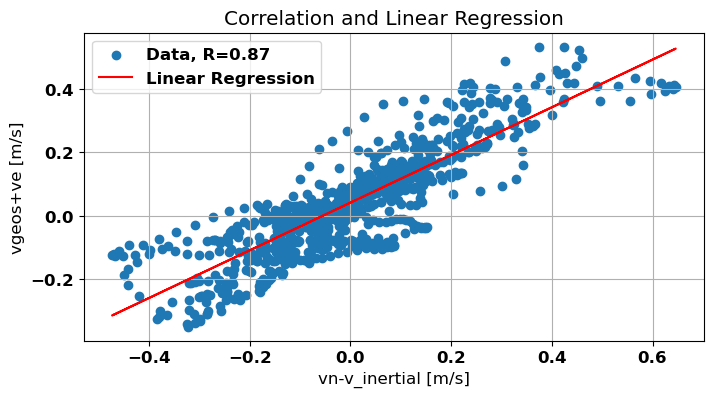

In [33]:
# According to the following, we can simply note that the correlation between "vn" and "vgeos + ve" is 0.84. 
# This means strong relationship between the variables
# Calcul de la corrélation spatiale et temporelle Pearson
bouees_courant_v = vn_filter_Han
correlation, p_value = pearsonr(dF['v_total'],bouees_courant_v)

print("Corrélation de Pearson:", correlation)
print("Valeur de p (p-value):", p_value)

# Fit linear regression model

slope, intercept, _, _, _ = linregress( bouees_courant_v,dF['v_total'])

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(bouees_courant_v,dF['v_total'], label=f'Data, R={correlation:.2f}')
plt.plot(bouees_courant_v, slope*bouees_courant_v + intercept, color='red', label='Linear Regression')
plt.xlabel('vn-v_inertial [m/s]')
plt.ylabel('vgeos+ve [m/s]')
plt.legend()
plt.title('Correlation and Linear Regression')
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'

# save graphe
plt.savefig("fig18 mode.png")
# Show plot
plt.show()

## Spline smoothing using the functional approach of Ramsay and Silverman.

## Case of ve and vn

In [34]:
# Lissage par splines avec l'approche fonctionnelle de Ramsay et Silverman
# ce code utilise la méthode LOWESS(Locally Weighted Scatterplot Smoothing) pour ajuster localement les données de vitesse par rapport au temps, en appliquant un 
# lissage qui prend en compte les relations locales entre les points. Cela permet de réduire le bruit tout en conservant les tendances générales et les contours
# nets des données originales, selon le paramètre frac spécifié.

lowess = sm.nonparametric.lowess(df_2['ve'], df_2['time'], frac=0.01)

temps_smoothed = lowess[:, 0]
vitesse_smoothed_ve = lowess[:, 1]

lowess = sm.nonparametric.lowess(df_2['vn'], df_2['time'], frac=0.01)

temps_smoothed = lowess[:, 0]
vitesse_smoothed_vn = lowess[:, 1]

## New comparison between (ve_filter and u_total) and (vn_filter and v_total) 

## ve_filter and u_total

Corrélation de Pearson: 0.826331196572917
Valeur de p (p-value): 2.0304443887461132e-204


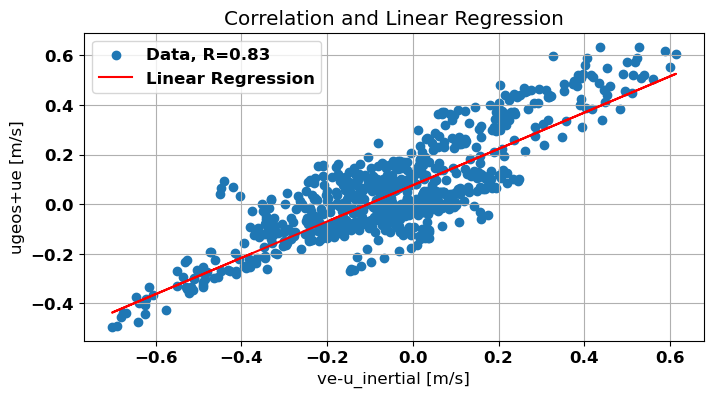

In [35]:
# According to the following, we can simply note that the correlation between "ve_filter" and "ugeos + ue" is 0.83. 
# This means that there is a positive and strong relationship  between this two variables.
# Calcul de la corrélation spatiale et temporelle Pearson
bouees_courant_u = vitesse_smoothed_ve
correlation, p_value = pearsonr(dF['u_total'],bouees_courant_u)

print("Corrélation de Pearson:", correlation)
print("Valeur de p (p-value):", p_value)

# Fit linear regression model

slope, intercept, _, _, _ = linregress( bouees_courant_u,dF['u_total'])

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(bouees_courant_u,dF['u_total'], label=f'Data, R={correlation:.2f}')
plt.plot(bouees_courant_u, slope*bouees_courant_u + intercept, color='red', label='Linear Regression')
plt.xlabel('ve-u_inertial [m/s]')
plt.ylabel('ugeos+ue [m/s]')
plt.legend()
plt.title('Correlation and Linear Regression')
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'

# save graphe
plt.savefig("fig19 mode.png")
# Show plot
plt.show()

## vn_filter and v_total

Corrélation de Pearson: 0.8615028449588797
Valeur de p (p-value): 6.249588266463958e-241


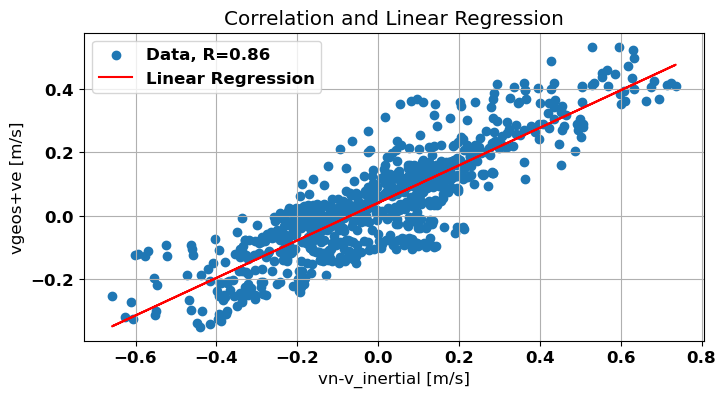

In [36]:
# According to the following, we can simply note that the correlation between "vn" and "vgeos + ve" is 0.86. 
# This means that there is a positive and strong relationship  between this two variables.
# Calcul de la corrélation spatiale et temporelle Pearson
bouees_courant_v = vitesse_smoothed_vn
correlation, p_value = pearsonr(dF['v_total'],bouees_courant_v)

print("Corrélation de Pearson:", correlation)
print("Valeur de p (p-value):", p_value)

# Fit linear regression model

slope, intercept, _, _, _ = linregress( bouees_courant_v,dF['v_total'])

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(bouees_courant_v,dF['v_total'], label=f'Data, R={correlation:.2f}')
plt.plot(bouees_courant_v, slope*bouees_courant_v + intercept, color='red', label='Linear Regression')
plt.xlabel('vn-v_inertial [m/s]')
plt.ylabel('vgeos+ve [m/s]')
plt.legend()
plt.title('Correlation and Linear Regression')
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'

# save graphe
plt.savefig("fig20 mode.png")
# Show plot
plt.show()

### Resume

### Zonal components currents

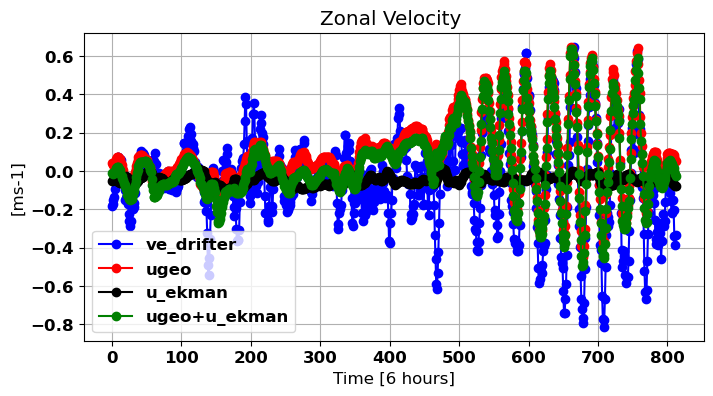

In [37]:
# Tracer le graphique
plt.figure(figsize=(8, 4))
plt.plot(df_2['ve'],marker='o', linestyle='-', color='blue',label='ve_drifter')
plt.plot(satellitaires_courant_u,marker='o', linestyle='-', color='red',label='ugeo')
plt.plot(satellite_ue,marker='o', linestyle='-', color='k',label='u_ekman')
plt.plot(dF['u_total'],marker='o', linestyle='-', color='g',label='ugeo+u_ekman')

plt.title('Zonal Velocity ')
plt.xlabel('Time [6 hours]')
plt.ylabel('[ms-1]')
plt.grid(True)
plt.legend()
plt.savefig("fig21 mode.png")
plt.show()

### Meridional components currents

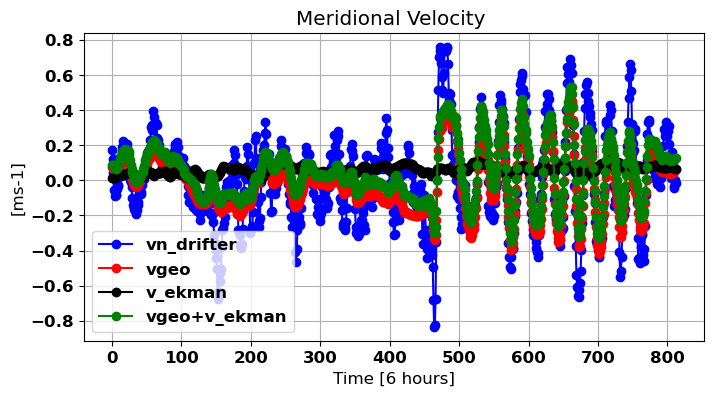

In [38]:
# Tracer le graphique
plt.figure(figsize=(8, 4))
plt.plot(df_2['vn'],marker='o', linestyle='-', color='blue',label='vn_drifter')
plt.plot(satellitaires_courant_v,marker='o', linestyle='-', color='red',label='vgeo')
plt.plot(satellite_ve,marker='o', linestyle='-', color='k',label='v_ekman')
plt.plot(dF['v_total'],marker='o', linestyle='-', color='g',label='vgeo+v_ekman')

plt.title('Meridional Velocity ')
plt.xlabel('Time [6 hours]')
plt.ylabel('[ms-1]')
plt.grid(True)
plt.legend()
plt.savefig("fig22 mode.png")
plt.show()

## Spline smoothing using the functional approach of Ramsay and Silverman.

### Zonal components currents

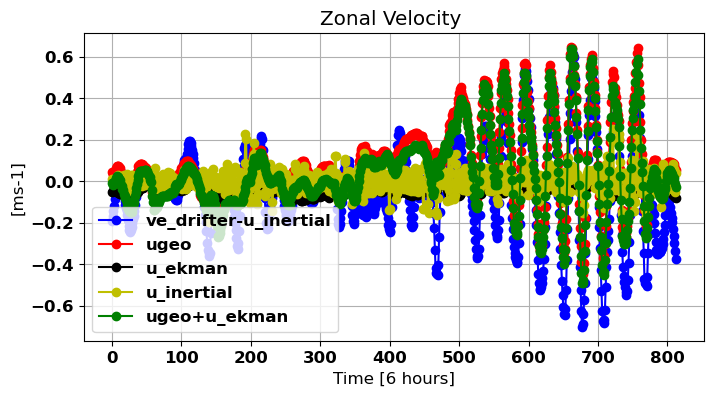

In [39]:
# Tracer le graphique
plt.figure(figsize=(8, 4))
plt.plot(vitesse_smoothed_ve, marker='o', linestyle='-', color='blue',label='ve_drifter-u_inertial')
plt.plot(satellitaires_courant_u,marker='o', linestyle='-', color='red',label='ugeo')
plt.plot(satellite_ue,marker='o', linestyle='-', color='k',label='u_ekman')
plt.plot(df_2['ve']-vitesse_smoothed_ve, marker='o', linestyle='-', color='y',label='u_inertial')
plt.plot(dF['u_total'],marker='o', linestyle='-', color='g',label='ugeo+u_ekman')

plt.title('Zonal Velocity ')
plt.xlabel('Time [6 hours]')
plt.ylabel('[ms-1]')
plt.grid(True)
plt.legend()
plt.savefig("fig23 mode.png")
plt.show()

### Meridional components currents

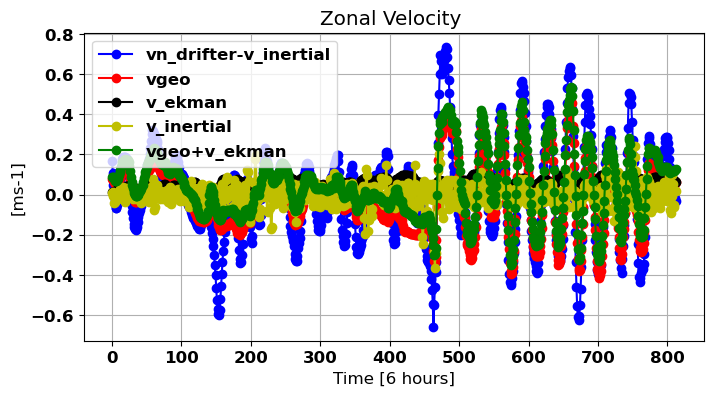

In [40]:
# Tracer le graphique
plt.figure(figsize=(8, 4))
plt.plot(vitesse_smoothed_vn, marker='o', linestyle='-', color='blue',label='vn_drifter-v_inertial')
plt.plot(satellitaires_courant_v,marker='o', linestyle='-', color='red',label='vgeo')
plt.plot(satellite_ve,marker='o', linestyle='-', color='k',label='v_ekman')
plt.plot(df_2['vn']-vitesse_smoothed_vn, marker='o', linestyle='-', color='y',label='v_inertial')
plt.plot(dF['v_total'],marker='o', linestyle='-', color='g',label='vgeo+v_ekman')

plt.title('Zonal Velocity ')
plt.xlabel('Time [6 hours]')
plt.ylabel('[ms-1]')
plt.grid(True)
plt.legend()
plt.savefig("fig24 mode.png")
plt.show()

## Conclusion
-  Strong correlation between drifter currents and altimetry currents (CMEMS Current).
-  Total altimetric zonal component slightly dominated by the total meridional component.